In [951]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [952]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [953]:
df = pd.read_sql_query("SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE (cast(t.completedDateTime as Date) = cast(getdate() as Date)) AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service')\
    ORDER BY completedDateTime DESC", cnxn)

In [954]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 28 2022 3:18PM,19,"GUSA Granules USA, Inc.",Picking,Edwin Perez,15
1,Mar 28 2022 3:18PM,19,Dexcel Pharma Technologies Ltd. DBA WDSrx,Picking,Angel Luna,15
2,Mar 28 2022 3:17PM,19,"GUSA Granules USA, Inc.",Picking,Edwin Perez,15
3,Mar 28 2022 3:17PM,15,"Alliance Pharma, Inc.",Picking,Karen Hernandez,15
4,Mar 28 2022 3:17PM,20,Alumier Labs Inc.,Picking,Wendy Medrano,15
...,...,...,...,...,...,...
3110,Mar 28 2022 7:44AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,7
3111,Mar 28 2022 7:42AM,20,Alumier Labs Inc.,Picking,Wendy Medrano,7
3112,Mar 28 2022 7:40AM,20,Alumier Labs Inc.,Manual Pick Allocation,Maria Ramos,7
3113,Mar 28 2022 7:39AM,20,Alumier Labs Inc.,Manual Pick Allocation,Maria Ramos,7


### Warehouse Activity

In [955]:
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse

,warehouse,operationCode
0,10,961
1,102,5
2,12,125
3,15,391
4,16,68
5,17,34
6,18,93
7,19,395
8,20,626
9,21,318


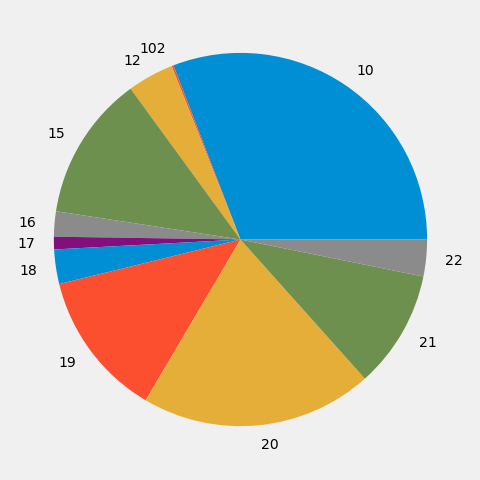

In [956]:
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

plt.subplots(figsize=(8,8))
plt.pie(activity, labels=warehouse)
plt.show()

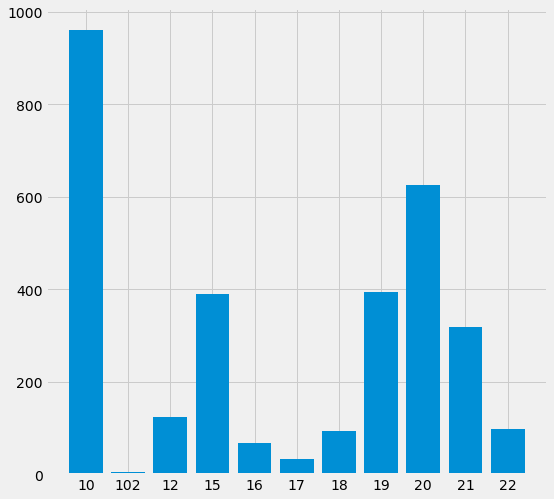

In [957]:
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

plt.subplots(figsize=(8,8))
plt.bar(warehouse, activity)
plt.show()

In [958]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index

,operationCode
warehouse,
10,961
102,5
12,125
15,391
16,68
17,34
18,93
19,395
20,626


### Operations type

In [959]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation

,operationCode,project
0,Batch Move,208
1,Count,43
2,Create Inventory,3
3,DONE RECEIVING,23
4,DRIVER CHECK IN,15
5,Finished Receiving,9
6,Inventory Adjustment,10
7,Lot Status Change,130
8,Manual Pick Allocation,200
9,Material Status Change,3


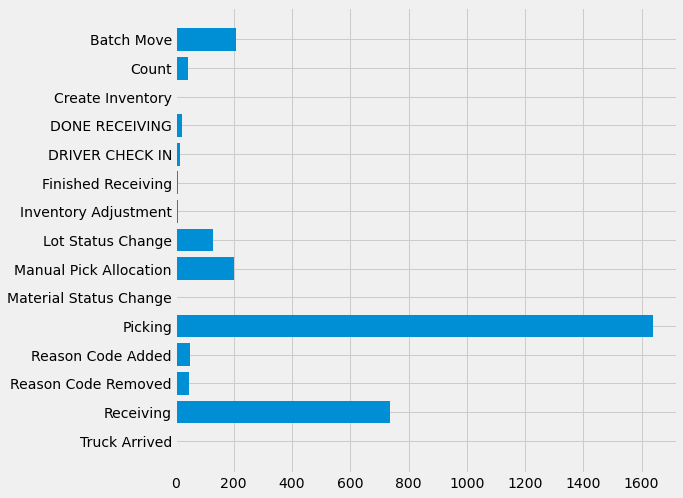

In [960]:
values = df_operation['project']
operation = df_operation['operationCode']

plt.subplots(figsize=(8,8))
plt.barh(operation, values)
plt.gca().invert_yaxis()
plt.show()

In [961]:
df_operation.rename(columns={"project": "Tasks"})
df_operation

,operationCode,project
0,Batch Move,208
1,Count,43
2,Create Inventory,3
3,DONE RECEIVING,23
4,DRIVER CHECK IN,15
5,Finished Receiving,9
6,Inventory Adjustment,10
7,Lot Status Change,130
8,Manual Pick Allocation,200
9,Material Status Change,3


In [962]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index

,Tasks
operationCode,
Batch Move,208
Count,43
Create Inventory,3
DONE RECEIVING,23
DRIVER CHECK IN,15
Finished Receiving,9
Inventory Adjustment,10
Lot Status Change,130
Manual Pick Allocation,200


### Operations per Hour

In [963]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours

,Hour,operationCode
0,7,54
1,8,177
2,9,384
3,10,429
4,11,539
5,12,463
6,13,423
7,14,463
8,15,183


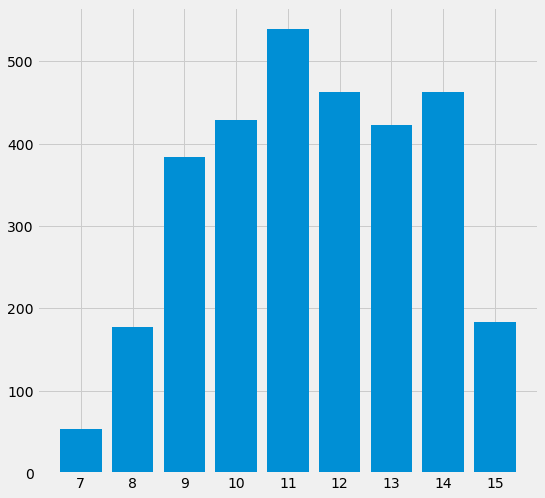

In [964]:
hour = df_hours['Hour']
activity = df_hours['operationCode']

plt.subplots(figsize=(8,8))
plt.bar(hour, activity)
plt.xticks(hour)
plt.show()

In [965]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index

,Operations
Hour,
7,54
8,177
9,384
10,429
11,539
12,463
13,423
14,463
15,183


# PICKING

In [966]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [967]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,3
1,Aisha Cooper,9,3
2,Aisha Cooper,10,4
3,Aisha Cooper,12,1
4,Aisha Cooper,15,2


In [968]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted

,7,8,9,10,11,12,13,14,15
employee,,,,,,,,,
Aisha Cooper,0.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0,2.0
Andre Nau,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
Angel Luna,0.0,5.0,24.0,20.0,7.0,2.0,6.0,24.0,7.0
Angela Pena,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
Baldomero Ramos,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Brad Bacchetti,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
Carlos Gomez,0.0,0.0,17.0,0.0,17.0,7.0,0.0,0.0,0.0
Carly Potts,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Djenyson Sanon,0.0,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0


### Save in JSON File

In [969]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers

employee,Aisha Cooper,Andre Nau,Angel Luna,Angela Pena,Baldomero Ramos,Brad Bacchetti,Carlos Gomez,Carly Potts,Djenyson Sanon,Doris Hincapie,...,Raul Bejarano,Reggie Bracken,Rita Geldres,Ronald Celis,Sergio Piura,Shannon Williamson,Wendy Medrano,William Trevino Trevino,Yaima Castillo,yudisel tubella
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0
8,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,13.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0
9,3.0,0.0,24.0,0.0,0.0,0.0,17.0,0.0,10.0,1.0,...,0.0,2.0,28.0,4.0,0.0,15.0,21.0,0.0,0.0,0.0
10,4.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,21.0,0.0,2.0,41.0,0.0,8.0,11.0
11,0.0,2.0,7.0,0.0,1.0,1.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,18.0,26.0,0.0,19.0,14.0
12,1.0,1.0,2.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,...,0.0,0.0,0.0,4.0,59.0,0.0,77.0,0.0,35.0,0.0
13,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0
14,0.0,0.0,24.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,2.0,0.0,0.0,4.0,0.0,84.0,16.0,0.0,0.0
15,2.0,0.0,7.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,8.0,1.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,1.0


# Picking and W-10

In [970]:
# Filtered by Picking and Warehouse
df_picking_10 = df_picking[df_picking['warehouse'] == '10']
df_picking_10.head()

,Date,warehouse,project,operationCode,employee,Hour
14,Mar 28 2022 3:15PM,10,ISDIN Corporation,Picking,Hugo Gonzales,15
18,Mar 28 2022 3:14PM,10,ISDIN Corporation,Picking,Hugo Gonzales,15
27,Mar 28 2022 3:13PM,10,ISDIN Corporation,Picking,Hugo Gonzales,15
33,Mar 28 2022 3:13PM,10,TherapeuticsMD Sample,Picking,Edilberto Souza,15
37,Mar 28 2022 3:12PM,10,ISDIN Corporation,Picking,Hugo Gonzales,15


In [971]:
# Grouped by Employee and Hour
df_picking_10_grouped = df_picking_10.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_10_grouped.reset_index(inplace=True)
df_picking_10_grouped.head()

,employee,Hour,operationCode
0,Carlos Gomez,9,17
1,Carlos Gomez,11,17
2,Carlos Gomez,12,7
3,Carly Potts,12,1
4,Djenyson Sanon,8,4


In [972]:
# Pivot
df_picking_10_pivoted = df_picking_10_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_10_pivoted = df_picking_10_pivoted.fillna(0)
df_picking_10_pivoted = df_picking_10_pivoted.rename_axis(None, axis=1)
#df_picking_10_pivoted.reset_index(inplace=True)

df_picking_10_pivoted

,8,9,10,11,12,13,14,15
employee,,,,,,,,
Carlos Gomez,0.0,17.0,0.0,17.0,7.0,0.0,0.0,0.0
Carly Potts,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Djenyson Sanon,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
Edilberto Souza,1.0,6.0,3.0,0.0,0.0,3.0,21.0,1.0
Frantz Laman,0.0,0.0,0.0,0.0,16.0,7.0,20.0,5.0
Hugo Gonzales,30.0,15.0,0.0,0.0,0.0,0.0,10.0,13.0
Jackson Pierre,0.0,0.0,0.0,0.0,0.0,62.0,38.0,0.0
Jayalakshmi Arcot,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Nelson Hurtado,0.0,0.0,0.0,0.0,1.0,2.0,14.0,0.0


### Save in JSON File

In [973]:
# Save into JSON
pickers_W10 = df_picking_10_pivoted.T
pickers_W10.to_json('data/pickers_w10.json')
pickers_W10

employee,Carlos Gomez,Carly Potts,Djenyson Sanon,Edilberto Souza,Frantz Laman,Hugo Gonzales,Jackson Pierre,Jayalakshmi Arcot,Nelson Hurtado,Rita Geldres,Ronald Celis,Sergio Piura
8,0.0,0.0,4.0,1.0,0.0,30.0,0.0,0.0,0.0,13.0,0.0,0.0
9,17.0,0.0,10.0,6.0,0.0,15.0,0.0,0.0,0.0,28.0,4.0,0.0
10,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0
11,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
12,7.0,1.0,0.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,4.0,59.0
13,0.0,0.0,0.0,3.0,7.0,0.0,62.0,0.0,2.0,0.0,0.0,3.0
14,0.0,0.0,0.0,21.0,20.0,10.0,38.0,0.0,14.0,0.0,0.0,4.0
15,0.0,0.0,0.0,1.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0


In [974]:
df_picking_10_pivoted_T = df_picking_10_pivoted.T
df_picking_10_pivoted_T

employee,Carlos Gomez,Carly Potts,Djenyson Sanon,Edilberto Souza,Frantz Laman,Hugo Gonzales,Jackson Pierre,Jayalakshmi Arcot,Nelson Hurtado,Rita Geldres,Ronald Celis,Sergio Piura
8,0.0,0.0,4.0,1.0,0.0,30.0,0.0,0.0,0.0,13.0,0.0,0.0
9,17.0,0.0,10.0,6.0,0.0,15.0,0.0,0.0,0.0,28.0,4.0,0.0
10,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0
11,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
12,7.0,1.0,0.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,4.0,59.0
13,0.0,0.0,0.0,3.0,7.0,0.0,62.0,0.0,2.0,0.0,0.0,3.0
14,0.0,0.0,0.0,21.0,20.0,10.0,38.0,0.0,14.0,0.0,0.0,4.0
15,0.0,0.0,0.0,1.0,5.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0


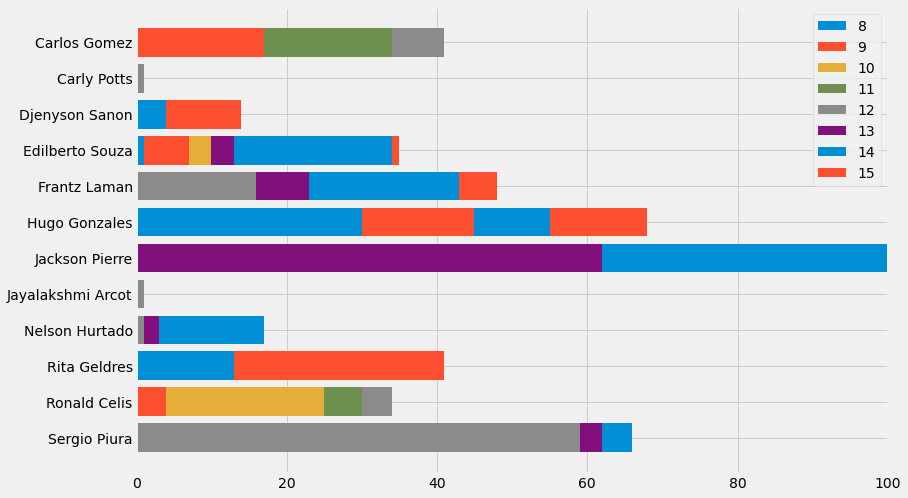

In [975]:
# Horizontal Chart
labels = df_picking_10_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

left_hour = [0.] * df_picking_10_pivoted_T.shape[1]

for i in df_picking_10_pivoted_T.index:
    ax.barh(labels, df_picking_10_pivoted_T.loc[i].values, left = left_hour)
    left_hour += df_picking_10_pivoted_T.loc[i].values

ax.legend(df_picking_10_pivoted_T.index)
plt.gca().invert_yaxis()
plt.show()

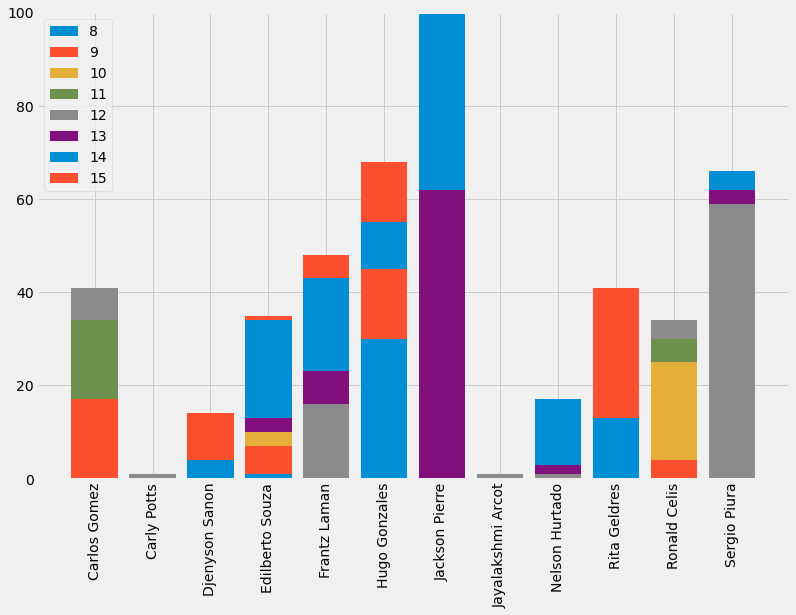

In [976]:
# Vertical Chart
labels = df_picking_10_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

bottom_hour = [0.] * df_picking_10_pivoted_T.shape[1]

for i in df_picking_10_pivoted_T.index:
    ax.bar(labels, df_picking_10_pivoted_T.loc[i].values, bottom = bottom_hour)
    bottom_hour += df_picking_10_pivoted_T.loc[i].values

ax.legend(df_picking_10_pivoted_T.index)

plt.xticks(rotation=90)
plt.show()

# Picking and W-20

In [977]:
# Filtered by Picking and Warehouse
df_picking_20 = df_picking[df_picking['warehouse'] == '20']
df_picking_20.head()

,Date,warehouse,project,operationCode,employee,Hour
4,Mar 28 2022 3:17PM,20,Alumier Labs Inc.,Picking,Wendy Medrano,15
6,Mar 28 2022 3:17PM,20,Alumier Labs Inc.,Picking,Wendy Medrano,15
7,Mar 28 2022 3:16PM,20,Alumier Labs Inc.,Picking,Wendy Medrano,15
11,Mar 28 2022 3:15PM,20,"ACI Healthcare USA, Inc.",Picking,Aisha Cooper,15
15,Mar 28 2022 3:15PM,20,Alumier Labs Inc.,Picking,Wendy Medrano,15


In [978]:
# Grouped by Employee and Hour
df_picking_20_grouped = df_picking_20.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_20_grouped.reset_index(inplace=True)
df_picking_20_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,3
1,Aisha Cooper,9,3
2,Aisha Cooper,10,4
3,Aisha Cooper,12,1
4,Aisha Cooper,15,2


In [979]:
# Pivot
df_picking_20_pivoted = df_picking_20_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_20_pivoted = df_picking_20_pivoted.fillna(0)
df_picking_20_pivoted = df_picking_20_pivoted.rename_axis(None, axis=1)
#df_picking_10_pivoted.reset_index(inplace=True)

df_picking_20_pivoted

,7,8,9,10,11,12,13,14,15
employee,,,,,,,,,
Aisha Cooper,0.0,3.0,3.0,4.0,0.0,1.0,0.0,0.0,2.0
Ernest Ferguson,0.0,0.0,2.0,1.0,3.0,0.0,0.0,1.0,2.0
Gregory Watts,0.0,0.0,0.0,0.0,0.0,0.0,6.0,13.0,3.0
Reggie Bracken,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0
Wendy Medrano,19.0,52.0,21.0,41.0,26.0,77.0,14.0,84.0,28.0


### Save in JSON File

In [980]:
pickers_W20 = df_picking_20_pivoted.T
pickers_W20.to_json('data/pickers_w20.json')
pickers_W20

employee,Aisha Cooper,Ernest Ferguson,Gregory Watts,Reggie Bracken,Wendy Medrano
7,0.0,0.0,0.0,0.0,19.0
8,3.0,0.0,0.0,0.0,52.0
9,3.0,2.0,0.0,2.0,21.0
10,4.0,1.0,0.0,0.0,41.0
11,0.0,3.0,0.0,0.0,26.0
12,1.0,0.0,0.0,0.0,77.0
13,0.0,0.0,6.0,0.0,14.0
14,0.0,1.0,13.0,2.0,84.0
15,2.0,2.0,3.0,1.0,28.0


In [981]:
df_picking_20_pivoted_T = df_picking_20_pivoted.T
df_picking_20_pivoted_T

employee,Aisha Cooper,Ernest Ferguson,Gregory Watts,Reggie Bracken,Wendy Medrano
7,0.0,0.0,0.0,0.0,19.0
8,3.0,0.0,0.0,0.0,52.0
9,3.0,2.0,0.0,2.0,21.0
10,4.0,1.0,0.0,0.0,41.0
11,0.0,3.0,0.0,0.0,26.0
12,1.0,0.0,0.0,0.0,77.0
13,0.0,0.0,6.0,0.0,14.0
14,0.0,1.0,13.0,2.0,84.0
15,2.0,2.0,3.0,1.0,28.0


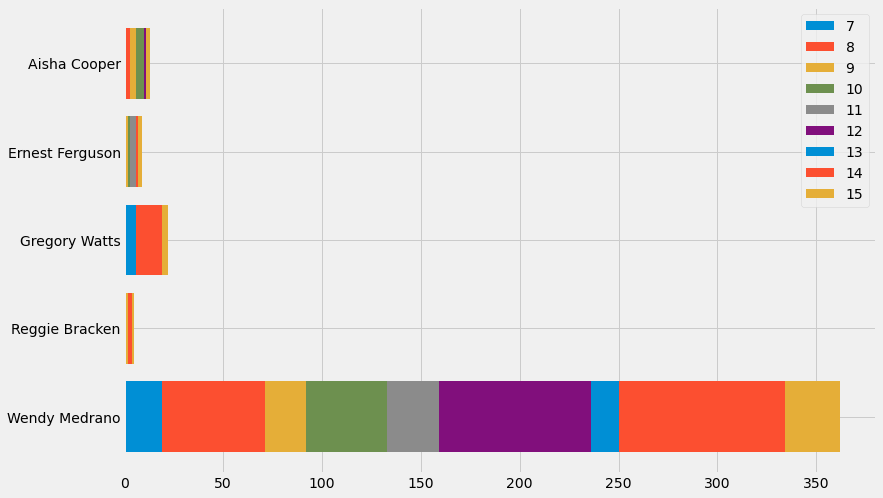

In [982]:
# Horizontal Chart
labels = df_picking_20_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

left_hour = [0.] * df_picking_20_pivoted_T.shape[1]

for i in df_picking_20_pivoted_T.index:
    ax.barh(labels, df_picking_20_pivoted_T.loc[i].values, left = left_hour)
    left_hour += df_picking_20_pivoted_T.loc[i].values

ax.legend(df_picking_20_pivoted_T.index)
plt.gca().invert_yaxis()
plt.show()

In [983]:
df_picking_20_pivoted_T.index

Int64Index([7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')

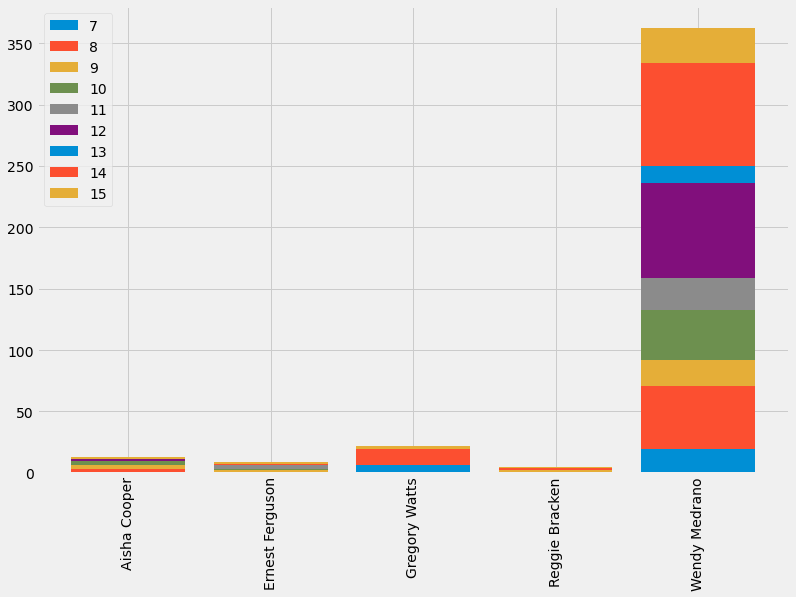

In [984]:
# Vertical Chart
labels = df_picking_20_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

bottom_hour = [0.] * df_picking_20_pivoted_T.shape[1]

for i in df_picking_20_pivoted_T.index:
    ax.bar(labels, df_picking_20_pivoted_T.loc[i].values, bottom = bottom_hour)
    bottom_hour += df_picking_20_pivoted_T.loc[i].values

ax.legend(df_picking_20_pivoted_T.index)

plt.xticks(rotation=90)
plt.show()

# QUERY 02: Open Outbounds

In [985]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [986]:
df_02

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447
...,...,...,...,...
7827,18,"Blinc International, Inc. - PVecom",IF-2087222,2022-03-28 15:10:34.587
7828,18,"Blinc International, Inc. - PVecom",IF-2087223,2022-03-28 15:10:35.210
7829,18,"Blinc International, Inc. - PVecom",IF-2087224,2022-03-28 15:10:35.883
7830,18,"Blinc International, Inc. - PVecom",IF-2087225,2022-03-28 15:10:36.523


In [987]:
df_02.dtypes

warehouse                     object
project                       object
shipment_number               object
createdSysDateTime    datetime64[ns]
dtype: object

In [988]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1706 days 06:08:58.368237
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,910 days 04:27:57.422237
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,864 days 22:41:22.772237
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,796 days 01:57:54.502237
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,796 days 01:57:54.118237
...,...,...,...,...,...
7827,18,"Blinc International, Inc. - PVecom",IF-2087222,2022-03-28 15:10:34.587,0 days 00:07:32.978237
7828,18,"Blinc International, Inc. - PVecom",IF-2087223,2022-03-28 15:10:35.210,0 days 00:07:32.355237
7829,18,"Blinc International, Inc. - PVecom",IF-2087224,2022-03-28 15:10:35.883,0 days 00:07:31.682237
7830,18,"Blinc International, Inc. - PVecom",IF-2087225,2022-03-28 15:10:36.523,0 days 00:07:31.042237


In [989]:
df_02.dtypes

warehouse                      object
project                        object
shipment_number                object
createdSysDateTime     datetime64[ns]
age_order             timedelta64[ns]
dtype: object

In [990]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1706 days 06:08:58.368237,1706,6
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,910 days 04:27:57.422237,910,4
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,864 days 22:41:22.772237,864,22
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,796 days 01:57:54.502237,796,1
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,796 days 01:57:54.118237,796,1
...,...,...,...,...,...,...,...
7827,18,"Blinc International, Inc. - PVecom",IF-2087222,2022-03-28 15:10:34.587,0 days 00:07:32.978237,0,0
7828,18,"Blinc International, Inc. - PVecom",IF-2087223,2022-03-28 15:10:35.210,0 days 00:07:32.355237,0,0
7829,18,"Blinc International, Inc. - PVecom",IF-2087224,2022-03-28 15:10:35.883,0 days 00:07:31.682237,0,0
7830,18,"Blinc International, Inc. - PVecom",IF-2087225,2022-03-28 15:10:36.523,0 days 00:07:31.042237,0,0


In [991]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [992]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [993]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [994]:
df_02_grouped

,orders
age_group,
24 Hours,928
48 Hours,176
72 Hours,242
1 Week,870
1 Month,1014
2 Months,706
3 Months,664
1 Year,2175
2 Years,996


### Save in JSON File

In [995]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,928
48 Hours,176
72 Hours,242
1 Week,870
1 Month,1014
2 Months,706
3 Months,664
1 Year,2175
2 Years,996


<AxesSubplot:ylabel='age_group'>

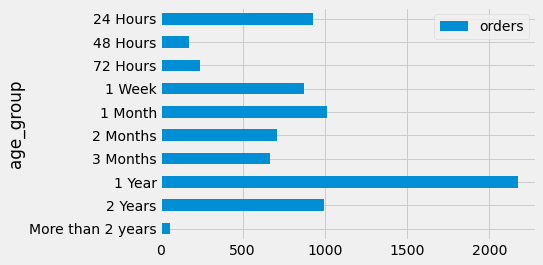

In [996]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

In [997]:
# Close connection
cnxn.close()